This notebook manually tests the conditional normalizing flows implementation in TensorFlow probability (with our changes)

The goal is to reproduce a two-dimensional conditional distribution.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tqdm import trange

import activelearning as al

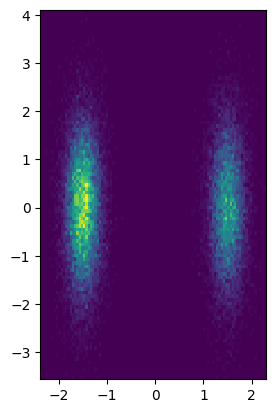

In [8]:
def get_p_batch(batch_size,conditional_y):
    w=0.2
    d=conditional_y[:,None]
    prob=0.4
    # return prob * gaussian(Environment.lambdas + 0.5 * d, w) \
    #        + (1 - prob) * gaussian(Environment.lambdas - 0.5 * d, w)

    g1 = np.random.randn(d.shape[0],batch_size)*w + 0.5*d
    g2 = np.random.randn(d.shape[0],batch_size)*w - 0.5*d

    p = np.random.binomial(1,prob,[d.shape[0],batch_size])

    g = np.random.randn(d.shape[0],batch_size)
    return np.dstack([p*g1 + (1-p)*g2,g])

plt.figure()
plt.hist2d(*get_p_batch(30000,np.array([3,2,1.]))[0].T,100);
plt.gca().set_aspect("equal")

In [10]:
net = al.distributions.ConditionalNormalizingFlow(
    dim=2,
    dim_conditions=1,
    num_bijectors=4,
    conditional_arguments_max=1,
)

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


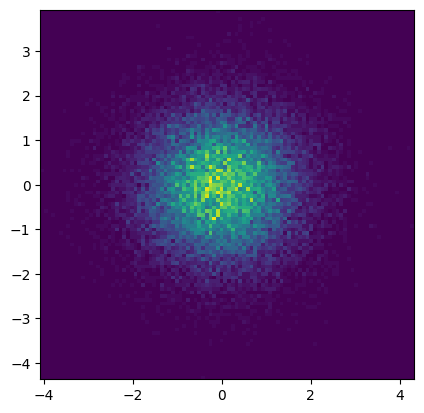

In [11]:
n_samples = 30000
net_samples = net.sample(n_samples, conditional_arguments=tf.zeros([n_samples,1]))

plt.figure()
plt.hist2d(*net_samples.numpy().T,100);
plt.gca().set_aspect("equal")

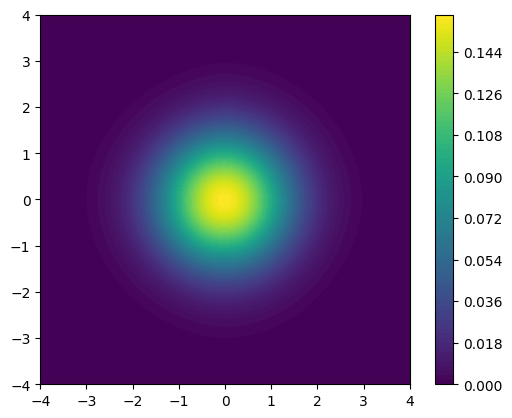

In [12]:
n_prob = 100
l1,l2 = np.meshgrid(np.linspace(-4,4,n_prob),np.linspace(-4,4,n_prob))
l_input = np.dstack([l1.flatten(),l2.flatten()])[0]
net_prob = net.prob(l_input, conditional_arguments=tf.zeros([n_prob**2,1]))

plt.figure()
plt.contourf(l1,l2,net_prob.numpy().reshape([n_prob,n_prob]),100);
plt.colorbar()
plt.gca().set_aspect("equal")

In [13]:
batch_size = 100
opt = tf.optimizers.Adam()
losses=[]

In [14]:
@tf.function
def train_step(tf_in,tf_conditional_y):
    with tf.GradientTape() as tape:
        log_prob = net.log_prob(tf_in, conditional_arguments=tf_conditional_y/5)
        # log_prob = tf.clip_by_value(log_prob,-1.e30,1000000)
        tf_loss = -tf.reduce_mean(log_prob)
        tf_loss = tf.debugging.check_numerics(tf_loss, "is the prob too small?")
    grads = tape.gradient(tf_loss, net.trainable_variables)
    # clipped = [tf.clip_by_value(grad, -10,10) for grad in grads]
    opt.apply_gradients(zip(grads,net.trainable_variables))
    return tf_loss

for _ in trange(50000):
    conditional_y = np.random.uniform(0,5,[batch_size,1])
    tf_conditional_y = tf.convert_to_tensor(conditional_y,K.backend.floatx())
    x_in = get_p_batch(1,conditional_y[:,0])[:,0]
    tf_in = tf.convert_to_tensor(x_in, K.backend.floatx())
    tf_loss = train_step(tf_in,tf_conditional_y)
    losses.append(tf_loss.numpy())

  0%|          | 0/50000 [00:00<?, ?it/s]2023-06-11 08:14:56.576726: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x41a1ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-11 08:14:56.576814: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-06-11 08:14:57.365214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-11 08:14:58.513079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-11 08:14:59.617331: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 50000/50000 [11:27<00:00, 72.69it/s]


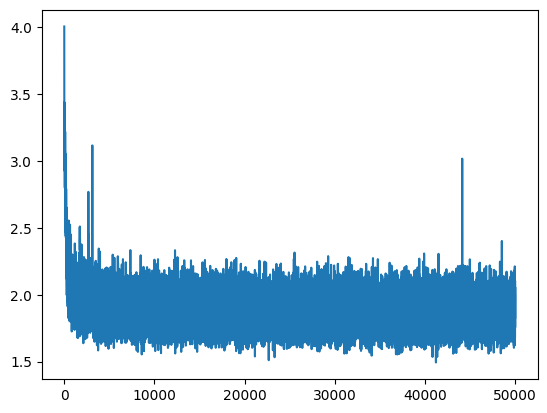

In [15]:
plt.plot(losses)

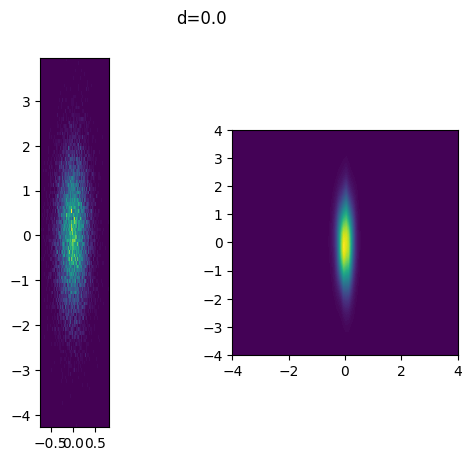

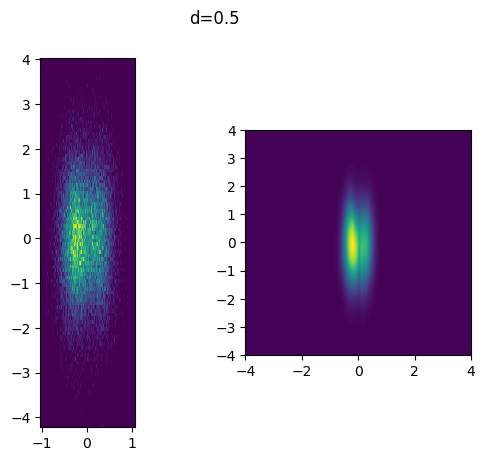

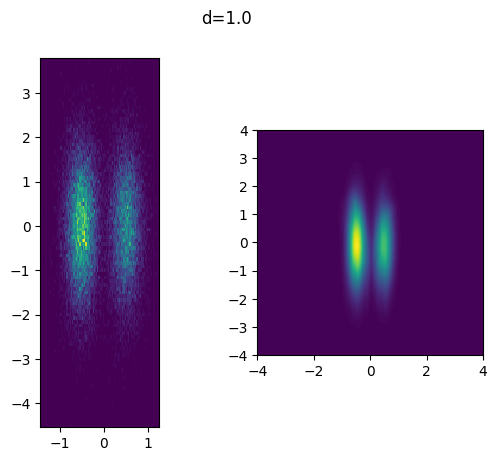

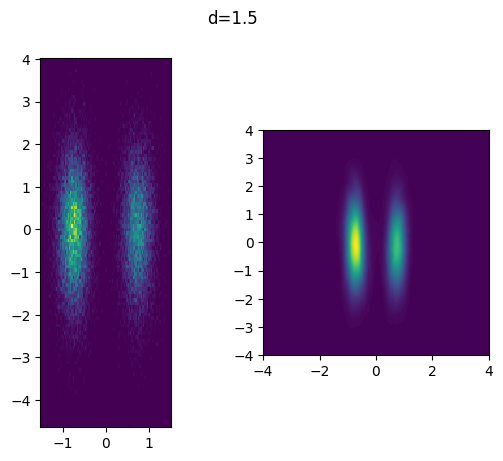

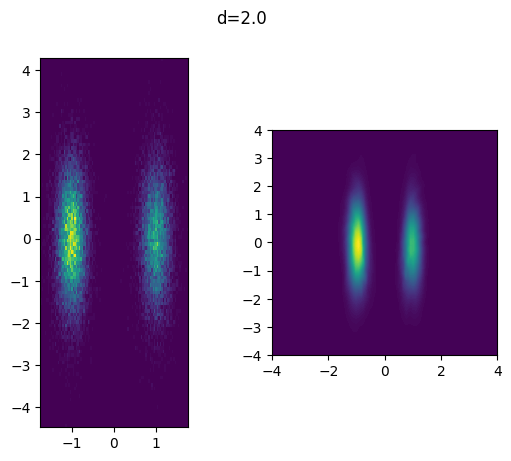

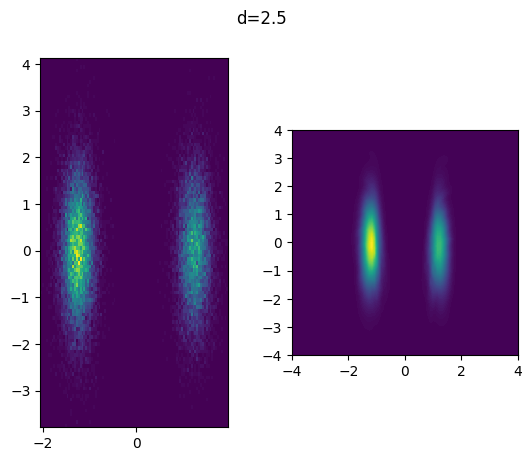

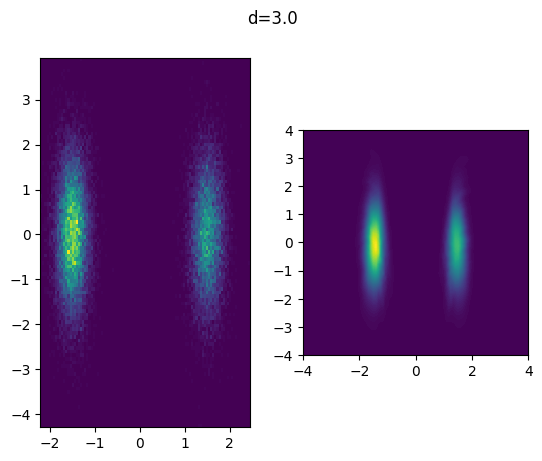

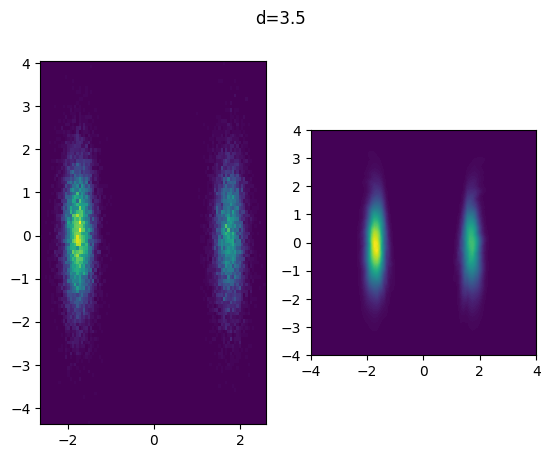

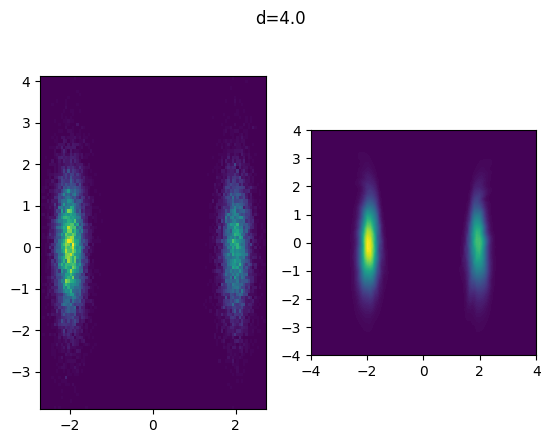

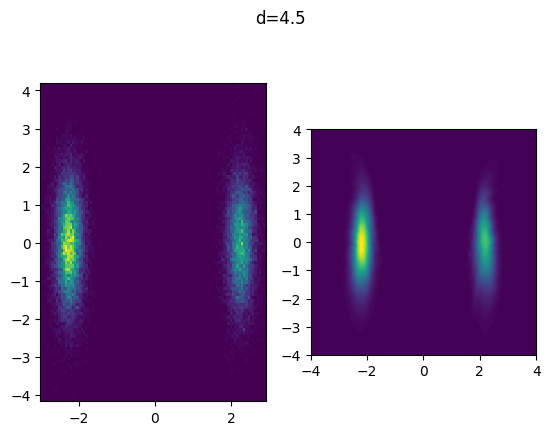

In [16]:
for dist in np.arange(0,5,0.5):
    l_out = net.prob(l_input,conditional_arguments=tf.ones([len(l_input),1],dtype=K.backend.floatx())*dist/5).numpy().T
    plt.figure()
    plt.suptitle(f"d={dist}")
    plt.subplot(1,2,1)
    plt.hist2d(*get_p_batch(30000,np.array([dist]))[0].T,100);
    plt.gca().set_aspect("equal")

    plt.subplot(1,2,2)
    plt.contourf(l1,l2,l_out.reshape([100,100]),100);
    # plt.colorbar()
    plt.gca().set_aspect("equal")
    plt.show()